<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 2 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the star_rating column, etc. You'll probably want to clean that stuff up for a better analysis.

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques:
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee: 

In [1]:
import pandas as pd

shops = pd.read_csv('./data/yelp_coffeeshop_review_data.csv')
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [2]:
shops.shape

(7616, 3)

In [3]:
# why are there duplicates in full_review_text?
shops.describe(exclude='number')

,coffee_shop_name,full_review_text,star_rating
count,7616,7616,7616
unique,79,6915,5
top,Epoch Coffee,11/10/2016 7 check-ins The Factory Cafe is ov...,5.0 star rating
freq,400,4,3780


In [4]:
# find out how to get int value for star_rating
int(shops['star_rating'][0].strip().split('.')[0])

5

In [5]:
# apply to the column with a lambda function
shops['star_rating'] = shops['star_rating'].apply(lambda x: int(x.strip().split('.')[0]))
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4


In [6]:
shops.dtypes

coffee_shop_name    object
full_review_text    object
star_rating          int64
dtype: object

In [7]:
# need to get rid of annoying whitespace
shops['full_review_text'][0]

' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? '

In [8]:
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: x.strip())

In [9]:
# that's better
shops['full_review_text'][0]

'11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas?'

In [10]:
# put dates in their own column
shops['review_date'] = shops['full_review_text'].apply(lambda x: x.split()[0])
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atmo...,5,11/25/2016
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambian...",4,12/2/2016
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots I...,4,11/30/2016
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice s...,2,11/25/2016
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within t...,4,12/3/2016


In [11]:
# remove dates from full_review_text
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: ' '.join(x.split()[1:]))
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5,11/25/2016
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4,12/2/2016
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4,11/30/2016
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating Howe...,2,11/25/2016
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4,12/3/2016


In [12]:
# create num_check_in feature
# can be either "check-in" or "check-ins"
shops['num_check_in'] = shops['full_review_text'].apply(lambda x: x.split()[0] 
                                                        if x.split()[1]=='check-in' 
                                                        or x.split()[1]=='check-ins'
                                                        else 0)
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,num_check_in
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5,11/25/2016,1
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4,12/2/2016,0
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4,11/30/2016,1
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating Howe...,2,11/25/2016,0
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4,12/3/2016,1


In [13]:
# and remove the check-in from full_review_text
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: ' '.join(x.split()[2:]) 
                                                        if x.split()[1]=='check-in'
                                                        or x.split()[1]=='check-ins'
                                                        else x)
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,num_check_in
0,The Factory - Cafe With a Soul,Love love loved the atmosphere! Every corner o...,5,11/25/2016,1
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4,12/2/2016,0
2,The Factory - Cafe With a Soul,Listed in Brunch Spots I loved the eclectic an...,4,11/30/2016,1
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating Howe...,2,11/25/2016,0
4,The Factory - Cafe With a Soul,They are located within the Northcross mall sh...,4,12/3/2016,1


In [30]:
# make reviews lowercase so Spacy can detect stop words
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: x.lower())

,coffee_shop_name,full_review_text,star_rating,review_date,num_check_in,tokens
0,The Factory - Cafe With a Soul,love love loved the atmosphere! every corner o...,5,11/25/2016,1,"[love, love, loved, atmosphere!, every, corner..."
1,The Factory - Cafe With a Soul,"listed in date night: austin, ambiance in aust...",4,12/2/2016,0,"[listed, date, night:, austin,, ambiance, aust..."
2,The Factory - Cafe With a Soul,listed in brunch spots i loved the eclectic an...,4,11/30/2016,1,"[listed, brunch, spots, i, loved, eclectic, ho..."
3,The Factory - Cafe With a Soul,very cool decor! good drinks nice seating howe...,2,11/25/2016,0,"[very, cool, decor!, good, drinks, nice, seati..."
4,The Factory - Cafe With a Soul,they are located within the northcross mall sh...,4,12/3/2016,1,"[they, located, northcross, mall, shopping, ce..."


In [71]:
# imports and initialization
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load('en_core_web_sm')

#Tokenizer 
tokenizer = Tokenizer(nlp.vocab)

In [62]:
nlp.vocab['listed'].is_stop = True
nlp.vocab['listed'].is_stop

True

In [73]:
# Tokenizer Pipe

tokens = []

# Make the tokens
for doc in nlp.pipe(shops['full_review_text'], disable=['tagger', 'parser', 'ner']):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop==False) & (token.is_punct==False):
           doc_tokens.append(token.text)
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [74]:
shops['tokens'].head()

0    [love, love, loved, atmosphere, corner, coffee...
1    [listed, date, night, austin, ambiance, austin...
2    [listed, brunch, spots, loved, eclectic, homey...
3    [cool, decor, good, drinks, nice, seating, ove...
4    [located, northcross, mall, shopping, center, ...
Name: tokens, dtype: object

In [18]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [65]:
wc = count(shops['tokens'])

In [75]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
7,coffee,4210,8058,1.0,0.020962,0.020962,0.552784
154,place,3029,4264,2.0,0.011092,0.032055,0.397715
81,great,2438,3250,3.0,0.008455,0.040509,0.320116
253,it's,2061,3117,4.0,0.008109,0.048618,0.270614
165,like,2034,2902,5.0,0.007549,0.056167,0.267069


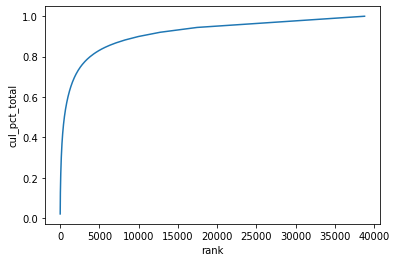

In [43]:
import seaborn as sns

# cumulative distribution plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

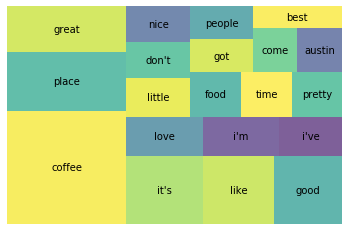

In [76]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.7)
plt.axis('off')
plt.show()

In [68]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,num_check_in,tokens
0,The Factory - Cafe With a Soul,love love loved the atmosphere! every corner o...,5,11/25/2016,1,"[love, love, loved, atmosphere!, corner, coffe..."
1,The Factory - Cafe With a Soul,"listed in date night: austin, ambiance in aust...",4,12/2/2016,0,"[date, night:, austin,, ambiance, austin, beau..."
2,The Factory - Cafe With a Soul,listed in brunch spots i loved the eclectic an...,4,11/30/2016,1,"[brunch, spots, loved, eclectic, homey, plush,..."
3,The Factory - Cafe With a Soul,very cool decor! good drinks nice seating howe...,2,11/25/2016,0,"[cool, decor!, good, drinks, nice, seating, ho..."
4,The Factory - Cafe With a Soul,they are located within the northcross mall sh...,4,12/3/2016,1,"[located, northcross, mall, shopping, center, ..."


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note*: [This](https://course.spacy.io) course will be of interest in helping you with these stretch goals.
* Try a different visualization techniques
* Try to build a plotly dash app with your text data